# Домашнее задание к занятию «Сингулярный спектральный анализ»


**Преподаватель:** Даниил Корбут, Наталья Баданина, Елена Харьковская

**Задание**

1. Возьмите из [прошлого домашнего задания](https://colab.research.google.com/github/stefkong1982/netology.ru/blob/Master/Vremennye_ryady/Znakomstvo_vremennymi_ryadami/DZ_Kondratev_Vr_ryady_ob_teor.ipynb#scrollTo=L2XHv4GZv6sT&line=1&uniqifier=1) ряд
2. Проведите анализ с помощью SSA
3. Посмотрите на результаты с разными длинами окон
4. Обязательно визуализируйте результаты аналогично материалу с занятия.

## 1. Загрузка данных

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
# Скачиваем данные из прошлого домашнего задания
airlines_passengers = pd.read_csv("https://raw.githubusercontent.com/stefkong1982/netology.ru/Master/Vremennye_ryady/Znakomstvo_vremennymi_ryadami/Series/international-airline-passengers.csv")

In [49]:
airlines_passengers.head()

,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [50]:
airlines_passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   144 non-null    object
 1   Count   144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


## 2. Визуализация временного ряда

In [51]:
import matplotlib.dates as mdates  # Импортируем matplotlib.dates

# Преобразуем колонку "Month" в формат даты
airlines_passengers['Month'] = pd.to_datetime(airlines_passengers['Month'])

# Устанавливаем колонку 'Month' в качестве индекса
airlines_passengers.set_index('Month', inplace=True)

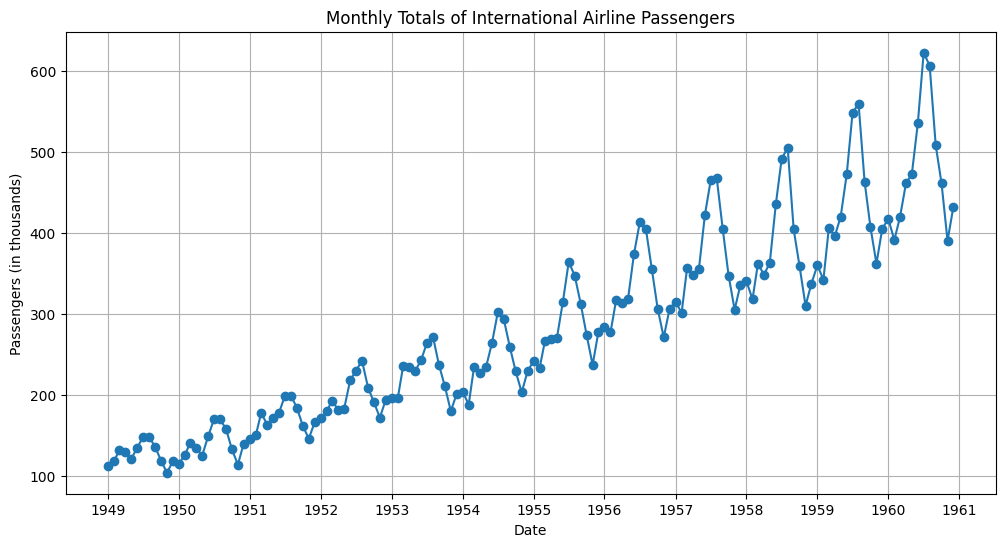

In [52]:
# Создаем график
plt.figure(figsize=(12, 6))
plt.plot(airlines_passengers.index, airlines_passengers['Count'], marker='o')
plt.title('Monthly Totals of International Airline Passengers')
plt.xlabel('Date')
plt.ylabel('Passengers (in thousands)')
plt.grid()

# Настраиваем отображение меток оси X
ax = plt.gca()  # Получаем текущую ось
ax.xaxis.set_major_locator(mdates.YearLocator())  # Устанавливаем метки с интервалом в 1 год
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Форматируем метки по годам

plt.show()

In [53]:
# Базовые статистические показатели
print(airlines_passengers.describe())

            Count
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


### Выводы на основе базовых статистических показателей:
Временной ряд международных авиапассажиров показывает растущий тренд с значительной вариативностью. Сезонные колебания, скорее всего, связаны с повышением пассажиропотока в летние месяцы и в праздники, что должно быть учтено при дальнейшей модели. Важно также обратить внимание на высокое стандартное отклонение, что позволяет заключить, что объемы авиапассажиров могут значительно варьироваться за каждый месяц. Эти аспекты требуют дальнейшего анализа, включая использование моделей авторегрессии условной гетероскедантичности (GARCH) для более глубокого понимания волатильности и для прогнозирования будущих значений.

## 3. Декомпозиция временного ряда

In [54]:
# для декомпозиции временного ряда можно использовать `statsmodels`.
from statsmodels.tsa.seasonal import seasonal_decompose

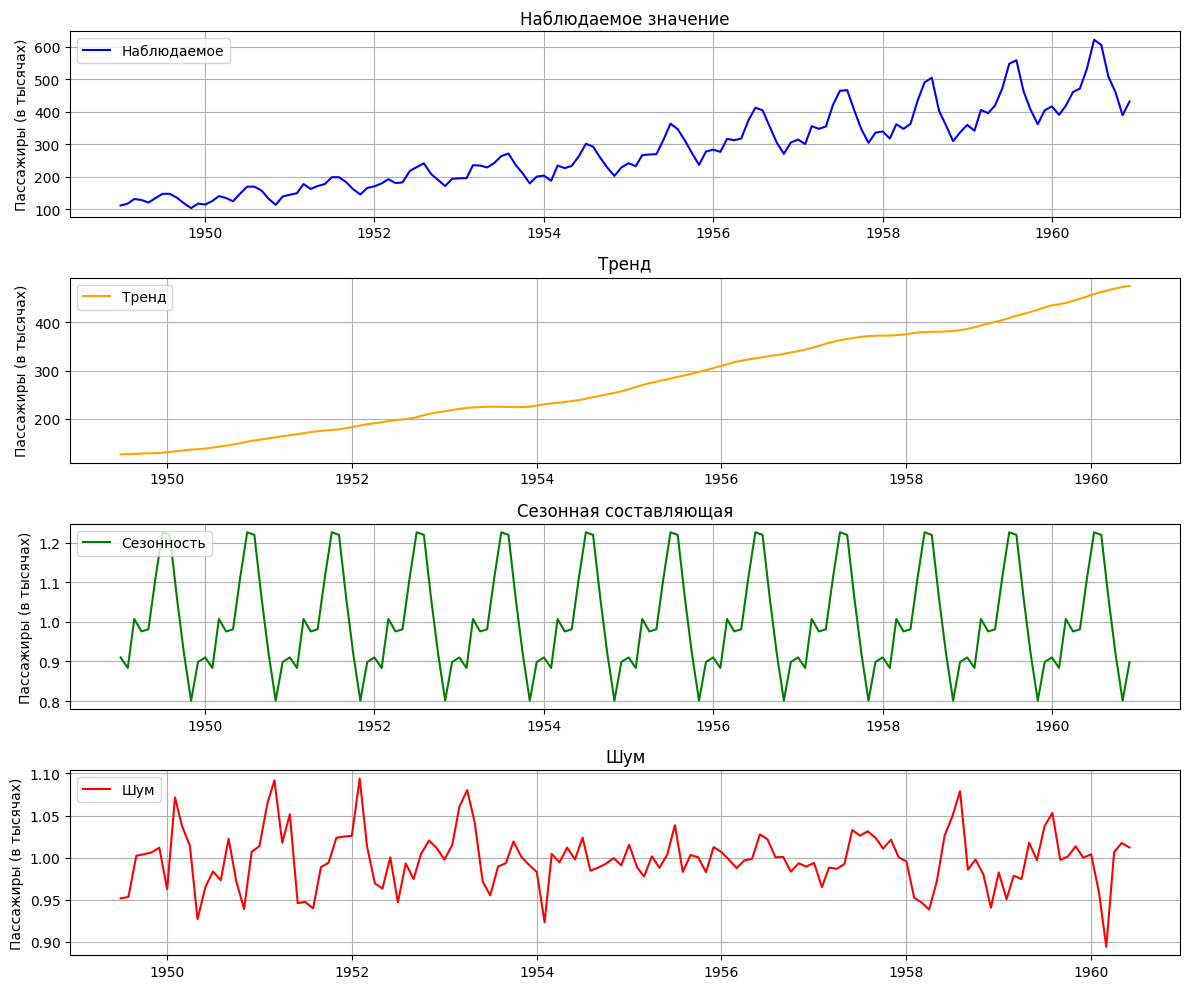

In [55]:
# Выполним декомпозицию
decomposition = seasonal_decompose(airlines_passengers['Count'], model='multiplicative')

# Визуализируем декомпозицию
plt.figure(figsize=(12, 10))

# Наблюдаемое значение
plt.subplot(411)
plt.plot(decomposition.observed, label='Наблюдаемое', color='blue')
plt.title('Наблюдаемое значение')
plt.ylabel('Пассажиры (в тысячах)')
plt.legend(loc='upper left')
plt.grid()

# Тренд
plt.subplot(412)
plt.plot(decomposition.trend, label='Тренд', color='orange')
plt.title('Тренд')
plt.ylabel('Пассажиры (в тысячах)')
plt.legend(loc='upper left')
plt.grid()

# Сезонная составляющая
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Сезонность', color='green')
plt.title('Сезонная составляющая')
plt.ylabel('Пассажиры (в тысячах)')
plt.legend(loc='upper left')
plt.grid()

# Шум
plt.subplot(414)
plt.plot(decomposition.resid, label='Шум', color='red')
plt.title('Шум')
plt.ylabel('Пассажиры (в тысячах)')
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

## 4. Создаем класс Python SSA, который будет использоваться

In [56]:
class SSA(object):

    __supported_types = (pd.Series, np.ndarray, list)

    def __init__(self, tseries, L, save_mem=True):
        """
        Выполняет разложение заданного временного ряда с помощью сингулярного спектрального анализа (SSA).
        Предполагается, что значения временного ряда записаны через равные интервалы.

        Параметры
        ----------
        tseries : pd.Series, np.ndarray, list
            Исходный временной ряд, представленный в виде объекта Pandas Series, NumPy массива или списка.

        L : int
            Длина окна. Должно быть целым числом 2 <= L <= N/2, где N - длина временного ряда.

        save_mem : bool
            Сохранять память, не храня элементарные матрицы. Рекомендуется для длинных временных рядов,
            содержащих тысячи значений. По умолчанию True.

        Примечание: Даже если для начального временного ряда используется массив NumPy или список,
        все возвращаемые временные ряды будут в виде объектов Pandas Series или DataFrame.
        """

        # Проверка типа для исходного временного ряда
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Неподдерживаемый объект временного ряда. Попробуйте использовать Pandas Series, NumPy массив или список.")

        # Проверка длины временного ряда
        self.N = len(tseries)
        if not 2 <= L <= self.N / 2:
            raise ValueError("Длина окна должна находиться в интервале [2, N/2].")

        self.L = L  # устанавливаем длину окна
        self.orig_TS = pd.Series(tseries)  # преобразование в Pandas Series
        self.K = self.N - self.L + 1  # количество возможных окон

        # Встраиваем временной ряд в матрицу траекторий
        self.X = np.array([self.orig_TS.values[i:L + i] for i in range(0, self.K)]).T

        # Декомпозиция матрицы траекторий с помощью SVD
        self.U, self.Sigma, VT = np.linalg.svd(self.X)  # SVD разложение
        self.d = np.linalg.matrix_rank(self.X)  # ранг матрицы

        # Инициализация массива для компонентов временного ряда
        self.TS_comps = np.zeros((self.N, self.d))

        if not save_mem:
            # Конструируем и сохраняем все элементарные матрицы
            self.X_elem = np.array([self.Sigma[i] * np.outer(self.U[:, i], VT[i, :]) for i in range(self.d)])

            # Диагонально усредняем элементарные матрицы и сохраняем их в виде столбцов в массиве
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:, i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0] + 1, X_rev.shape[1])]

            self.V = VT.T  # сохраняем матрицу V
        else:
            # Реконструируем элементарные матрицы без их хранения
            for i in range(self.d):
                X_elem = self.Sigma[i] * np.outer(self.U[:, i], VT[i, :])  # создаем элементарную матрицу
                X_rev = X_elem[::-1]  # инвертируем матрицу
                self.TS_comps[:, i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0] + 1, X_rev.shape[1])]

            self.X_elem = "Повторите запуск с save_mem=False, чтобы сохранить элементарные матрицы."

            # Также матрица V может быть очень большой, поэтому мы её не будем хранить.
            self.V = "Повторите запуск с save_mem=False, чтобы сохранить матрицу V."

        # Вычисляем w-матрицу корреляции.
        self.calc_wcorr()

    def components_to_df(self, n=0):
        """
        Возвращает все временные компоненты в едином объекте Pandas DataFrame.

        Параметры
        ----------
        n : int
            Количество компонентов, которые нужно вернуть. По умолчанию возвращаются все компоненты.

        Возвращает
        -------
        pd.DataFrame
            DataFrame, содержащий временные компоненты с именами столбцов F0, F1, F2, ...
        """
        if n > 0:
            n = min(n, self.d)  # не позволяет запросить больше компонентов, чем есть
        else:
            n = self.d  # возвращаем все компоненты

        # Создание списка названий столбцов
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)

    def reconstruct(self, indices):
        """
        Реконструирует временной ряд из его элементарных компонентов, используя заданные индексы.
        Возвращает объект Pandas Series с восстановленным временным рядом.

        Параметры
        ----------
        indices : int, list of int, slice
            Целое число, список целых чисел или объект среза(n,m),
            представляющий элементарные компоненты для суммирования.

        Возвращает
        -------
        pd.Series
            Восстановленный временной ряд.
        """
        if isinstance(indices, int):
            indices = [indices]  # задержка индексов для целого числа

        ts_vals = self.TS_comps[:, indices].sum(axis=1)  # суммируем выбранные компоненты
        return pd.Series(ts_vals, index=self.orig_TS.index)  # возвращаем восстановленный временной ряд

    def calc_wcorr(self):
        """
        Вычисляет w-матрицу корреляции для временного ряда.

        Эта матрица показывает корреляции между компонентами с учетом весов.
        Она используется для анализа взаимосвязей между компонентами временного ряда.
        """

        # Вычисляем веса
        w = np.array(list(np.arange(self.L) + 1) + [self.L] * (self.K - self.L - 1) + list(np.arange(self.L) + 1)[::-1])

        def w_inner(F_i, F_j):
            """Внутреннее произведение с учетом весов."""
            return w.dot(F_i * F_j)

        # Вычисление взвешенных норм для последующего обобщения
        F_wnorms = np.array([w_inner(self.TS_comps[:, i], self.TS_comps[:, i]) for i in range(self.d)])
        F_wnorms = F_wnorms ** -0.5  # обратная величина весов

        # Расчет w-матрицы корреляции
        self.Wcorr = np.identity(self.d)  # инициализация единичной матрицы
        for i in range(self.d):
            for j in range(i + 1, self.d):  # вычисляем только верхнюю треугольную часть
                self.Wcorr[i, j] = abs(w_inner(self.TS_comps[:, i], self.TS_comps[:, j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j, i] = self.Wcorr[i, j]  # матрица симметрична

    def plot_wcorr(self, min=None, max=None):
        """
        Строит график w-матрицы корреляции для разложенного временного ряда.

        Параметры
        ----------
        min : int, optional
            Минимальный индекс для оси x. По умолчанию None.

        max : int, optional
            Максимальный индекс для оси x. По умолчанию None.
        """
        if min is None:
            min = 0  # если не задано, минимальный индекс равен 0
        if max is None:
            max = self.d  # если не задано, максимальный индекс равен размеру матрицы

        if self.Wcorr is None:
            self.calc_wcorr()  # если корреляция не была рассчитана, то вычисляем её

        ax = plt.imshow(self.Wcorr)  # создание графика
        plt.xlabel(r"$\tilde{F}_i$")  # подписи осей
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)  # цветовая шкала
        ax.colorbar.set_label("$W_{i,j}$")  # метка цветовой шкалы
        plt.clim(0, 1)  # установка пределов цветовой шкалы

        # Для целей построения:
        if max == self.d:
            max_rnge = self.d - 1
        else:
            max_rnge = max

        plt.xlim(min - 0.5, max_rnge + 0.5)  # границы по оси x
        plt.ylim(max_rnge + 0.5, min - 0.5)  # границы по оси y

## 5. Визуализация матрицы траекторий

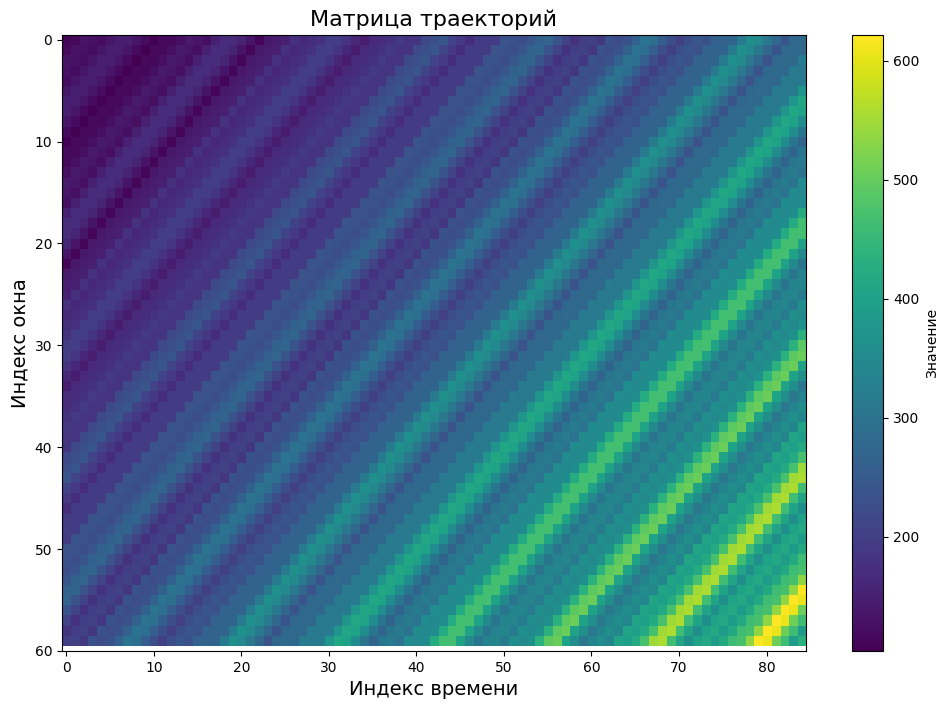

In [57]:
# Задаем длину окна
L = 60

# Создаем экземпляр класса SSA
ssa = SSA(airlines_passengers['Count'], L)

# Визуализируем матрицу траекторий
plt.figure(figsize=(12, 8))

# Для визуализации используем imshow для отображения матрицы X
plt.imshow(ssa.X, aspect='auto', cmap='viridis')

# Цветовая шкала с подписью на русском
plt.colorbar(label='Значение')  # Изменили на 'Значение'

# Заголовок графика на русском
plt.title('Матрица траекторий', fontsize=16)  # Изменили на 'Матрица траекторий'

# Подписи осей на русском
plt.xlabel('Индекс времени', fontsize=14)  # Изменили на 'Индекс времени'
plt.ylabel('Индекс окна', fontsize=14)    # Изменили на 'Индекс окна'

# Настройка меток осей
plt.xticks(ticks=np.arange(0, ssa.K, step=10),  # Создаем массив индексов от 0 до ssa.K (кол-во окон)
           labels=np.arange(0, ssa.K, step=10)) # Устанавливаем метки значений для этих индексов
plt.yticks(ticks=np.arange(0, L + 1, step=10),   # Создаем массив индексов от 0 до L (длина окна)
           labels=np.arange(0, L + 1, step=10))  # Устанавливаем метки значений для этих индексов

# Удаление сетки
plt.grid(False)

# Отображение графика
plt.show()

Анализ матрицы траекторий, полученной в результате сингулярного спектрального анализа (SSA), показывает растущий тренд с значительной вариативностью.

## 6. Эксперименты с длиной окна

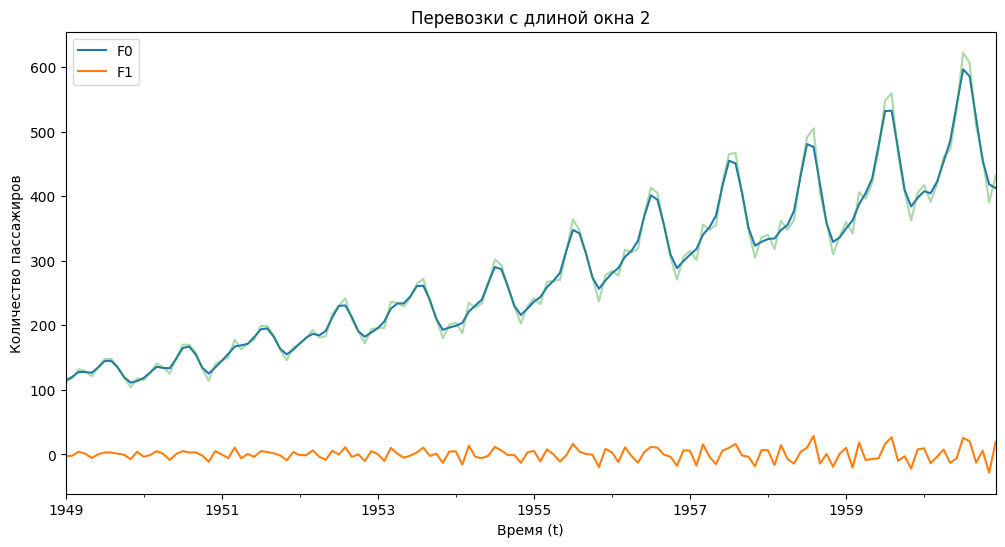

In [58]:
# Выполняем разложение временного ряда на компоненты с длиной окна 2
plt.figure(figsize=(12, 6))  # Ширина 12, высота 6 дюймов
F_ssa_L2 = SSA(airlines_passengers['Count'], 2)
components_df = F_ssa_L2.components_to_df() # Строим график компонент разложения
components_df.plot(ax=plt.gca())  # Указываем текущую ось для построения
F_ssa_L2.orig_TS.plot(ax=plt.gca(), alpha=0.4) # alpha определяет уровень прозрачности для оригинального ряда
plt.xlabel("Время (t)")
plt.ylabel("Количество пассажиров")
plt.title("Перевозки с длиной окна 2")
plt.show()

### Понимание длины окна \(L\)

Длина окна в методе SSA определяет, сколько значений временного ряда одновременно анализируется для извлечения компонент. В данном случае, при \(L=2\):

- **Ограниченное количество компонент**: Метод SSA выделяет столько компонент, сколько соответствует длине окна. Это означает, что с \(L=2\) мы можем ожидать получить только две отдельные компоненты: одну, которая может представлять общий тренд или взаимосвязь между данными, а другую, которая может представлять высокочастотные колебания или шум.

- **Простота анализа**: Даже с такой небольшой длиной окна метод показывает свою способность различать основную структуру данных от случайных колебаний. Это значит, что даже если вы хотите анализировать временной ряд с минимальным количеством компонент, SSA предоставляет возможность выделить полезную информацию, что может упростить дальнейший анализ.



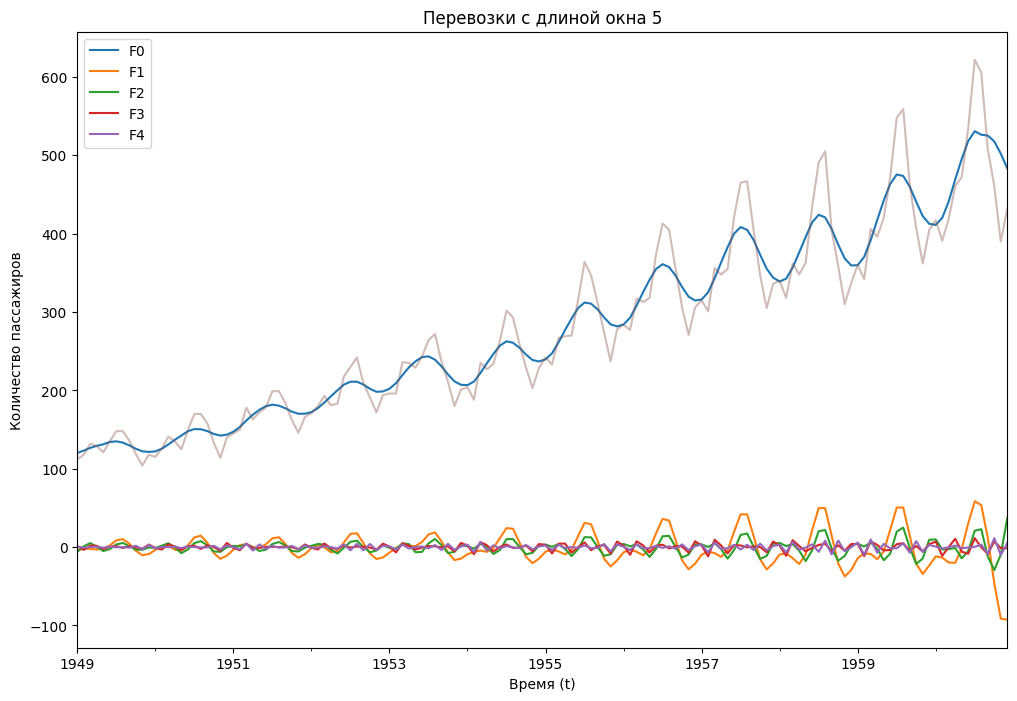

In [59]:
# Выполняем разложение временного ряда на компоненты с длиной окна 5
plt.figure(figsize=(12, 8))  # Ширина 12, высота 6 дюймов
F_ssa_L5 = SSA(airlines_passengers['Count'], 5)
components_df = F_ssa_L5.components_to_df() # Строим график компонент разложения
components_df.plot(ax=plt.gca())  # Указываем текущую ось для построения
F_ssa_L5.orig_TS.plot(ax=plt.gca(), alpha=0.4) # alpha определяет уровень прозрачности для оригинального ряда
plt.xlabel("Время (t)")
plt.ylabel("Количество пассажиров")
plt.title("Перевозки с длиной окна 5")
plt.show()

### Анализ компонентов

1. **F0: Главный тренд**
   - **Описание**: F0 "повторяет оригинальный ряд, но со сглаженными отклонениями". Это ключевая характеристика SSA, где основная компонента часто служит сглаженной версией исходных данных, позволяющей выделить долгосрочный тренд и устранить краткосрочные флуктуации и шум.

2. **F1 и F2: Сезонные колебания**
   - **Описание**: F1 и F2 "отражают сезонные колебания". Эти компоненты обычно представляют собой повторяющиеся колебания, связанные с определёнными временными интервалами, например, годовыми сезонами.

3. **F3 и F4: Шум**
   - **Описание**: F3 и F4 "похожи на шум". Это, вероятно, значит, что эти компоненты содержат случайные флуктуации, которые не соответствуют долгосрочным трендам или сезонным колебаниям.

### Длина окна и ее влияние на группировку

Важно отметить, что в данном эксперименте метод SSA применялся с длиной окна (L=5). Увеличение длины окна позволяет более точно выделять структуры временного ряда. Однако, учитывая, что F1 и F2 отвечают за схожие сезонные колебания, а F3 и F4 представляют шум, дальнейшее увеличение длины окна будет более обоснованным, если мы применим первичную группировку этих компонент.

Группировка компонент по их общей характеристике позволяет улучшить понимание структуры данных и уменьшить сложности анализа, сосредоточив внимание на более значимых паттернах. В этом контексте рекомендуется рассмотреть применение w-корреляционной матрицы для анализа связей между сгруппированными компонентами. Это поможет выявить их взаимосвязи и степень влияния на общий временной ряд.


Увеличим длину окна до 20, получим w-корреляционную матрицу и примем решения о группировке.

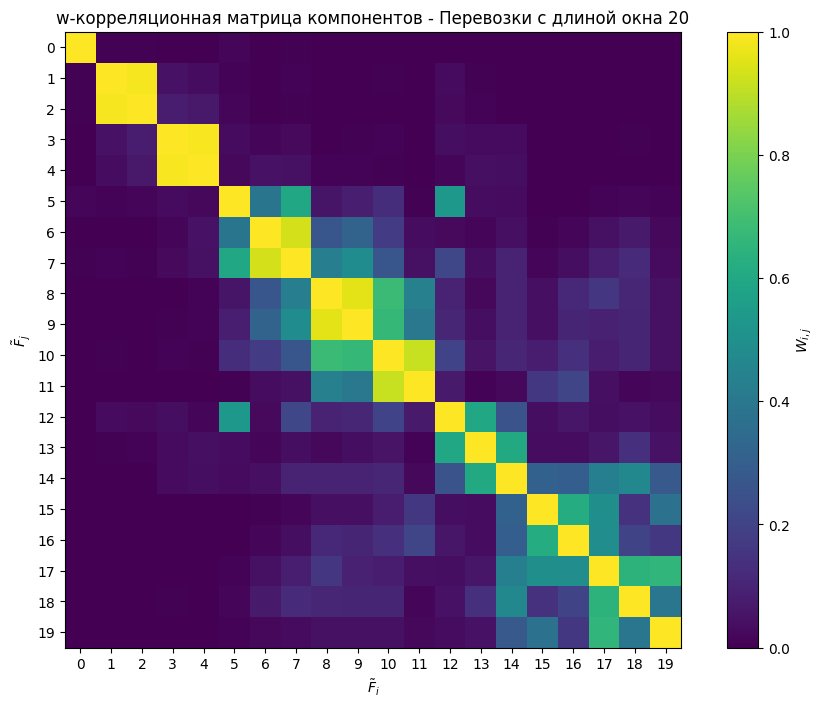

In [60]:
# Применяем Сингулярный Спектральный Анализ с длиной окна 20
window_length = 20
F_ssa_L20 = SSA(airlines_passengers['Count'], window_length)

# Создаем график w-корреляционной матрицы
plt.figure(figsize=(12, 8))
F_ssa_L20.plot_wcorr()

# Задаем заголовок графика
plt.title("w-корреляционная матрица компонентов - Перевозки с длиной окна 20")

# Устанавливаем шаг по осям равным количеству окон
plt.xticks(ticks=range(window_length))
plt.yticks(ticks=range(window_length))

# Отображаем график
plt.show()

w-корреляционная матрица для $L=20$ разбита на два блока: $\tilde{F}_0$ to $\tilde{F}_4$ и $\tilde{F}_5$ to $\tilde{F}_{19}$.

Посмотрим поближе на блок: $\tilde{F}_0$ to $\tilde{F}_4$

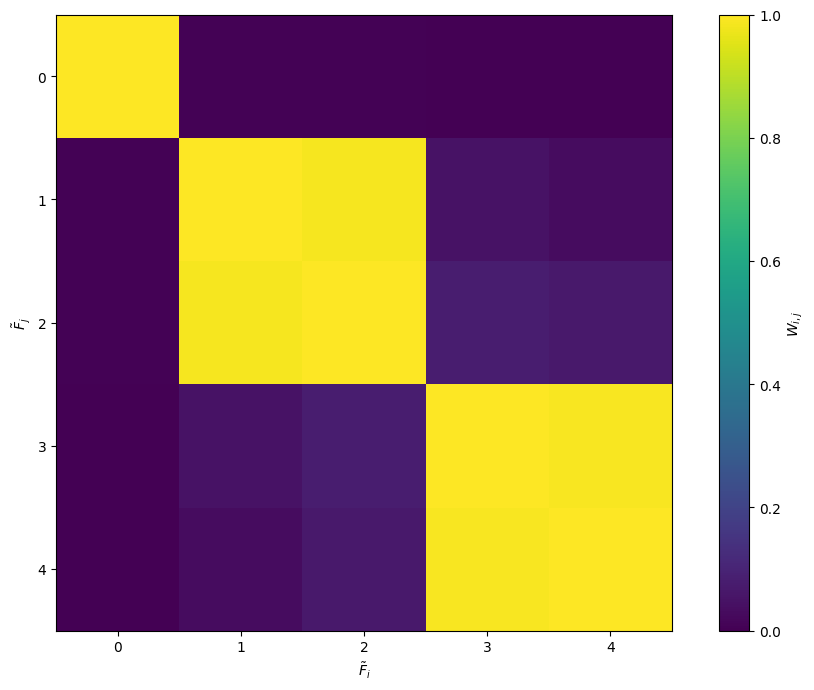

In [61]:
plt.figure(figsize=(12, 8))  # Увеличиваем размер графика до 12 на 8 дюймов
F_ssa_L20.plot_wcorr(max=4)  # Строим w-корреляционную матрицу с ограничением максимального значения по оси y

Размер значений $W_{i,j}$ предполагает, что нам нужно сгруппировать $\tilde{F}_1$ + $\tilde{F}_2$, $\tilde{F}_3$ + $\tilde{F}_4, $ а также сгруппировать все $ \tilde{F}_5, \ldots,\tilde{F}_{19}$.

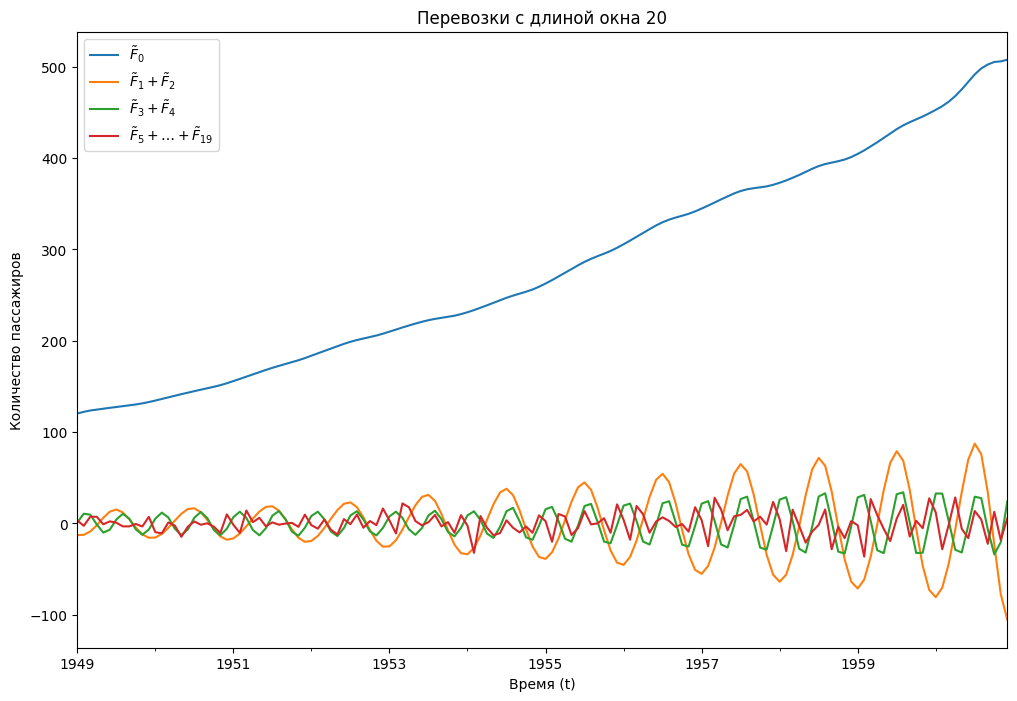

In [62]:
# Устанавливаем размер графика на 12 на 8 дюймов
plt.figure(figsize=(12, 8))

# Строим графики на основе реконструкции данных
F_ssa_L20.reconstruct(0).plot()
F_ssa_L20.reconstruct([1, 2]).plot()
F_ssa_L20.reconstruct([3, 4]).plot()
F_ssa_L20.reconstruct(slice(5, 20)).plot()

# Настраиваем метки осей и заголовок
plt.xlabel("Время (t)")
plt.ylabel("Количество пассажиров")
plt.title("Перевозки с длиной окна 20")

# Добавляем легенду с заданными параметрами
plt.legend([r"$\tilde{F}_0$",
            r"$\tilde{F}_1+\tilde{F}_2$",
            r"$\tilde{F}_3+\tilde{F}_4$",
            r"$\tilde{F}_5+ \ldots + \tilde{F}_{19}$"])

# Отображаем график
plt.show()

### Выводы из наблюдений

1. **Увеличение окна и его влияние на детали разложения**:
   - При увеличении длины окна до 20 было возможно более четкое разделение компонентов временного ряда. Четкое разделение главного тренда и сезонных составляющих наметилось, так как ранние этапы анализа с меньшими значениями длины окна показывали определенные смешения или совместные паттерны. Это подтверждает, что длина окна напрямую влияет на способность SSA выделять детали в данных.

2. **Составляющая \( $\tilde{F}_0$ \)**:
   - Компонента \( $\tilde{F}_0$ \) представляет собой главный тренд, который наглядно показывает долгосрочное повышение количества пассажиров. Это может быть связано с ростом авиаперевозок в международных масштабах и улучшением доступа к авиаперевозкам для широкой публики. Зафиксированный растущий тренд даже при достаточном шуме подчеркивает надежность базового роста сектора.

3. **Сумма составляющих \( $\tilde{F}_1$ \) и \( $\tilde{F}_2$ \)**:
   - Данные компоненты демонстрируют ярко выраженные периодические колебания, что указывает на наличие сезонных колебаний, связанных с разными периодами в году, например, праздниками, летними отпусками и другими факторами, влияющими на трафик пассажиров. Это вмешательство сезонности хорошо видимо и отличается от основного тренда.

4. **Сумма составляющих \( $\tilde{F}_3$ \) и \( $\tilde{F}_4$ \)**:
   - Эти компоненты также четко выделяются и отображают периодические колебания, что возможно связано с другими временными интервалами или эффектами, которые не были полностью учтены в первом анализе. Это подтверждает наличие многослойных сезонных эффектов в авиаперевозках.

5. **Сумма всех остальных компонентов \( $\tilde{F}_5$, $\ldots, \tilde{F}_{19}$ \)**:
   - Данная группа отображает уровень шума, который в своем большинстве является случайными флуктуациями. Этот шум может включать нерегулярные изменения, которые не имеют четкой сезонной составляющей или тренда и могут затруднять дальнейший анализ, если они не будут выделены.

### Рекомендация по дальнейшим экспериментам с увеличением окна

С точки зрения завершенности анализа, при текущей конфигурации длины окна (20) мы уже получили достаточно четкую картину о временном ряде. Основные компоненты: тренд, сезонные колебания и шум были явно разделены между собой.

**Рекомендуется воздержаться от дальнейших экспериментов с увеличением окна** по следующим причинам:

1. **Избыточная сложность**: Увеличение окна может привести к более сложным структурами разложения, которые труднее интерпретировать и превращает анализ в слишком детализированный без значительного увеличения полезной информации. Это может помешать выявлению ключевых тенденций.

2. **Уменьшение информативности**: Чем больше окно, тем труднее отделить некоторые компоненты, особенно если в данных присутствуют шумовые компоненты. Это может привести к тому, что новые выделенные компоненты будут слабо информативными и не будут представлять существенного интереса.

3. **Избыточное сглаживание**: Слишком длинные окна могут привести к чрезмерному сглаживанию, что делает невозможным выявление высокочастотных колебаний и неожиданных всплесков в данных.